In [13]:
import matplotlib.pyplot as plt
from matplotlib import style
import pybamm
from Durdel2023_single import get_test_parameter_values, get_final_parameter_values

In [14]:

"Primary Active Material"
rho_si = 2.336 #from ref (supplementary material)
wt_si = .679 #% from ref
"Secondary Active Material"
rho_c6 = 2.255 # (C-NERGYTM KS6L)
wt_c6 = .199
"Inactive Material"
rho_cb = 2.00 #from ref
wt_cb = 0.02 # from ref
rho_lipaa = 1.2 #ref
wt_lipaa = 0.082 # ref
rho_cmc = 1.6 #ref
wt_cmc = 0.002 #ref

v_tot  = wt_si/rho_si + wt_c6/rho_c6 + wt_cb/rho_cb + wt_lipaa/rho_lipaa + wt_cmc/rho_cmc
v_si = wt_si/rho_si
v_c6 = wt_c6/rho_c6
v_im = wt_c6/rho_c6 + wt_lipaa/rho_lipaa + wt_cmc/rho_cmc

eps_si = 0.5 * v_si / v_tot #times 0.5 to account for porosity (eps_ely = 0.5)
eps_c6 = 0.5 * v_c6 / v_tot
eps_am = 0.5* (v_si + v_c6) / v_tot

cell_volume = 0.0124*0.124*(92e-06 + 1.2e-05 + 2.6e-05 + 136e-06 +1.5e-05)

print("Volume fraction of Si: ", eps_si
      , "Volume fraction of C6: ", eps_c6, "Volume fraction of AM: ", eps_am, "cell volume: ", cell_volume)

Volume fraction of Si:  0.31697725057239584 Volume fraction of C6:  0.09623602768522001 Volume fraction of AM:  0.41321327825761583 cell volume:  4.3206559999999995e-07


In [15]:


model = pybamm.lithium_ion.DFN(
    {
     #"open-circuit potential": ("current sigmoid", "single"),
     #"working electrode": "negative",
     "SEI": "none",
     "lithium plating": "none",
    }
)

model.print_parameter_info()


┌───────────────────────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Parameter                                                 │ Type of parameter                                                                                                                                                                                           │
├───────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Initial temperature [K]                                   │ Parameter                                                                                                                             

In [16]:
param = pybamm.ParameterValues(get_final_parameter_values())

# param.update(
#     {
#         "Primary: Negative electrode active material volume fraction": 0.09623602768522001, # primary
#         "Secondary: Negative electrode active material volume fraction": 0.31697725057239584,
#         "Negative electrode porosity": 0.5,
#     }
#     )

param.update({
    "Minimum stoichiometry in negative electrode": 0.0387,
    "Maximum stoichiometry in negative electrode": 0.2960,
    "Minimum stoichiometry in positive electrode": 0.1396,
    "Maximum stoichiometry in positive electrode": 0.7954,
}, check_already_exists=False)


In [17]:
experiment = pybamm.Experiment(
    [
        (
            "Rest for 5 minutes",
            "Discharge at C/50 until 3.0 V",
            #"Rest for 2 hours",
            "Charge at C/50 until 4.2 V",
        ),
    ]
)


In [18]:
sim = pybamm.Simulation(
    model,
    parameter_values=param,
    experiment = experiment,
    #solver=pybamm.CasadiSolver(rtol=1e-3, atol=1e-3, mode='safe', return_solution_if_failed_early=True)
    solver=pybamm.IDAKLUSolver(rtol=1e-6, atol=1e-8)
)
solution = sim.solve()

xn = solution["X-averaged negative particle stoichiometry"].data
xp = solution["X-averaged positive particle stoichiometry"].data
print(xn.min(), xn.max(), xp.min(), xp.max())


2025-08-09 17:57:04.734 - [ERROR] callbacks.on_experiment_error(233): Simulation error: FAILURE IDA_ERR_FAIL: Error test failures occurred too many times during one internal time step or minimum step size was reached.


0.048469718537603616 0.17319999999999994 0.46750000000000014 0.7717179454521534


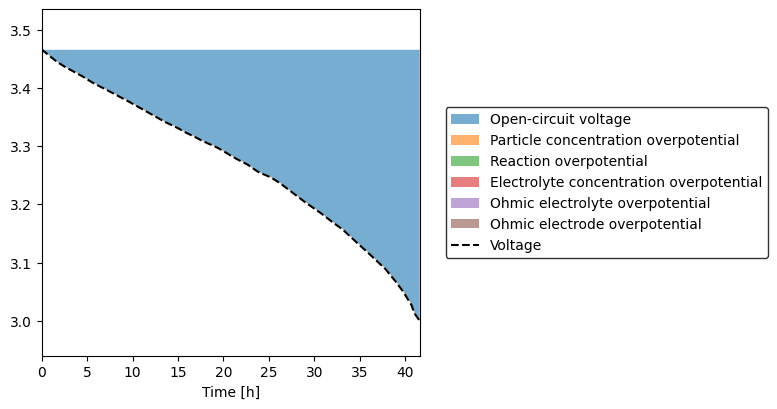

interactive(children=(FloatSlider(value=0.0, description='t', max=41.59535459249755, step=0.4159535459249755),…

In [19]:
pybamm.plot_voltage_components(solution)


sim.plot(output_variables=["Voltage [V]", 
                           "Current [A]",
                           "Negative particle surface concentration [mol.m-3]",
                           "Negative electrode potential [V]",
                           "Positive electrode potential [V]",
                           "X-averaged negative electrode open-circuit potential [V]"
                           ])